## Imports

In [1]:
import pickle
import gzip
import os
import time
import copy
import cv2

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

## Utility Functions

In [142]:
def print_train_data_point(item, verbose=False):
    name = item['name']   #
    video = item['video'] #
    box = item['box']
    label = item['label']
    frames = item['frames'] #
    dataset = item['dataset'] #
    
    print(f"Dataset: {dataset}, Name: {name}\nVideo Shape:   {video.shape}\nLabeld Frames: {frames}")
    if verbose:
        print(f"Box Shape:   {box.shape}\nLabel Shape: {label.shape}")
    print()
    
def resize_boolean_array(b_item, shape=(256, 256)):
    # Step 1: Convert boolean to uint8 (True -> 255, False -> 0)
    b_item_uint8 = b_item.astype(np.uint8) * 255
    
    # Step 2: Resize the array with nearest-neighbor interpolation
    size = (shape[1],shape[0])
    resized_item = cv2.resize(b_item_uint8, size, interpolation=cv2.INTER_NEAREST)
    
    # Step 3: Convert back to boolean (any value >= 127 is True)
    resized_item_boolean = resized_item >= 127
    
    return resized_item_boolean

def extract_box_center_batch(boolean_batch):
    
    batch_size = boolean_batch.shape[0]
    coordinates = []
    
    for i in range(batch_size):
        boolean_array = boolean_batch[i]
        height, width = boolean_array.shape
        #print(boolean_array)
        
        x1 = None
        y1 = None
        x2 = None
        y2 = None
        i = 0
        
        for h in range(height):
            for w in range(width):
                if boolean_array[h][w] == True:
                    x2, y2 = h, w
                    if (i==0):
                        x1, y1 = h, w
                    i += 1
        
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        coordinates.append((center_x, center_y))
            
    return torch.FloatTensor(np.array(coordinates))

def reconstruct_box_centers_batch(coords_batch, shape=(256,256), box_width=128, box_height=128):
    # box_width and box_height are swaped :D
    batch_size = coords_batch.shape[0]
    boxes = []
    half_width = box_width // 2
    half_height = box_height // 2 
    
    for i in range(batch_size):
        center_x, center_y = coords_batch[i,:].detach().numpy().astype(int)
        box = np.zeros(shape, dtype=bool)
        
        # Calculate box boundaries
        x1 = max(0, center_x - half_width)
        x2 = min(shape[0] - 1, center_x + half_width)
        y1 = max(0, center_y - half_height)
        y2 = min(shape[1] - 1, center_y + half_height)
        
        box[x1:x2+1, y1:y2+1] = True
        boxes.append(box)
    
    return torch.BoolTensor(np.array(boxes))


def substitute_with_my_box(box):
    #takes given box
    #returns box with same center but 128x128
    
    box_batch = torch.BoolTensor(box).unsqueeze(0)
    center_batch = extract_box_center_batch(box_batch)
    my_box_batch = reconstruct_box_centers_batch(center_batch)
    
    return my_box_batch[0].detach().numpy()

def get_cropped_frame(frame, box, shape=(128, 128)):

    height, width = box.shape
    
    cropped_frame = np.zeros((128, 128), dtype=float)
        
    x1 = None
    y1 = None
    x2 = None
    y2 = None
    i = 0

    for h in range(height):
        for w in range(width):
            if box[h][w] == True:
                x2, y2 = h, w
                if (i==0):
                    x1, y1 = h, w
                i += 1
                
    cropped_frame[0:(x2-x1), 0:(y2-y1)] = frame[x1:x2, y1+1:y2+1]
                    
    return cropped_frame

## Graphing Functions

In [7]:
def plot_frame(frame, title, mask=None):
    
    # Apply the mask to the copy if provided
    frame_with_mask = frame.copy()
    frame_without_mask = frame.copy()
    if mask is not None:
        frame_with_mask[~mask] = 0
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    # Plot the frame without mask
    axs[0].imshow(frame_without_mask, cmap='gray')
    title0 = title + " without mask"
    axs[0].set_title(title0)
    axs[0].axis('off')
    
    # Plot the frame with mask
    axs[1].imshow(frame_with_mask, cmap='gray')
    title1 = title + " with mask"
    axs[1].set_title(title1)
    axs[1].axis('off') 
    
    plt.tight_layout()
    plt.show()
    
def show_video(frames, masks, speed=0.025):
    
    video = frames.copy()
    masked_video = video * masks  # Apply the mask to each frame
    
    num_frames = video.shape[2]
    plt.figure(figsize=(10, 5))
    
    for i in range(num_frames):
        plt.clf()  # Clear the previous plot
        
        # Left subplot: Original video
        plt.subplot(1, 2, 1)
        plt.imshow(video[:, :, i], cmap='gray')
        plt.axis('off')
        plt.title(f"Original Frame {i+1}/{num_frames}")
        
        # Right subplot: Masked video
        plt.subplot(1, 2, 2)
        plt.imshow(masked_video[:, :, i], cmap='gray')
        plt.axis('off')
        plt.title(f"Masked Frame {i+1}/{num_frames}")
        
        # Display and wait
        display(plt.gcf())
        clear_output(wait=True)
        time.sleep(speed)

## Smoothing Function

In [32]:
def smooth_frame(image):
    image = cv2.GaussianBlur(image, (3, 3), 0)
    image = cv2.medianBlur(image, 3)
    return image

def smooth_video(video):
    for i in range(video.shape[0]):
        video[i,:,:] = smooth_frame(video[i,:,:])
    return video

## Load Data

In [76]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object
    
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")

train_data_amateurs = []
train_data_experts = []
train_data_all = []

for item in tqdm(train_data):
    if(item['dataset'] == "amateur"):
        train_data_amateurs.append(item)
    else:
        train_data_experts.append(item)
    train_data_all.append(copy.deepcopy(item))
        
print(f"Amateur Train set items:{len(train_data_amateurs)}")
print(f"Expert Train set items:{len(train_data_experts)}")
print(f"All Train set items:{len(train_data_all)}")
print(f"Test set items:{len(test_data)}")

100%|██████████| 65/65 [00:00<00:00, 137.33it/s]

Amateur Train set items:46
Expert Train set items:19
All Train set items:65
Test set items:20


In [77]:
def eliminate_exes(data_point):  
    video = data_point['video'] 
    frames = data_point['frames'] 
    label = data_point['label']
    
    height, width, n_frames = video.shape
    
    cut_video = np.zeros((height, width, len(frames)))
    cut_label = np.zeros((height, width, len(frames)))
    
    for i, f in enumerate(frames):
        cut_video[:, :, i] = video[:, :, f]
        cut_label[:, :, i] = label[:, :, f]
        
    data_point['video'] = cut_video
    data_point['label'] = cut_label

def clean_data(data):
    for item in tqdm(data):
        eliminate_exes(item)
        
# one time run!!
clean_data(train_data_amateurs)
clean_data(train_data_experts)
clean_data(train_data_all)
#          test_data

100%|██████████| 65/65 [00:00<00:00, 140.48it/s]


## Create Datasets

In [79]:
class EchoDataset(Dataset):
    def __init__(self, frames_data, boxes_data, labels_data, centers_data, transform=None):
        self.frames_data = frames_data  # list: (num_frames, height, width)
        self.boxes_data = boxes_data       # List: (num_frames, height, width)
        self.labels_data = labels_data     # List: (num_frames, height, width)
        self.centers_data = centers_data   # List: (num_frames, 2)
        
            
        self.cropped_frames_data = None
        self.cropped_labels_data = None
        
        self.box = False       #Using the dataset for the Box training
        self.unet = False      #Usinging the dataset for the segmentation training
        
        self.transform = transform

    def __getitem__(self, index):
        frame = self.frames_data[index]  # shape (height, width)
        #label = self.labels_data[index]   # shape (height, width)

        frame = torch.FloatTensor(frame) 
        #label = torch.FloatTensor(label) 
        
        if self.box:
            return frame, self.centers_data[index]
        
        if self.unet:
            cropped_frame = torch.FloatTensor(self.cropped_frames_data[index])
            cropped_label = torch.FloatTensor(self.cropped_labels_data[index])
            return cropped_frame, cropped_label

        return frame, torch.FloatTensor(self.boxes_data[index]), torch.FloatTensor(self.labels_data[index])

    def __len__(self):
        return len(self.frames_data)

In [80]:
def get_resized_list(data):
    f = []
    b = []
    l = []
    c = []
    
    for item in tqdm(data):
        for i in range(item['video'].shape[2]):
            f_item = item['video'][:,:,i] 
            b_item = item['box']
            l_item = item['label'][:,:,i]
            
            f.append(smooth_frame(cv2.resize(f_item.astype(np.uint8), (256, 256)) ))
            l.append(cv2.resize(l_item.astype(np.uint8), (256, 256)))
            
            box = resize_boolean_array(b_item, shape=(256, 256))
            b.append(box)
            
            box =  np.expand_dims(box, axis=0)
            c.append(extract_box_center_batch(box)[0].numpy()) 

    return f, b, l, c


f_a, b_a, l_a, c_a = get_resized_list(train_data_amateurs)
f_e, b_e, l_e, c_e = get_resized_list(train_data_experts)
f_ae, b_ae, l_ae, c_ae = get_resized_list(train_data_all)

100%|██████████| 65/65 [00:12<00:00,  5.23it/s]


In [81]:
amateur_train_dataset = EchoDataset(f_a, b_a, l_a, c_a)
expert_train_dataset = EchoDataset(f_e, b_e, l_e, c_e)
all_train_dataset = EchoDataset(f_ae, b_ae, l_ae, c_ae)


a = all_train_dataset.__len__()
b = amateur_train_dataset.__len__()
c = expert_train_dataset.__len__()

print(f"{a/3}, {b/3}, {c/3}")

65.0, 46.0, 19.0


## Dataset Testing

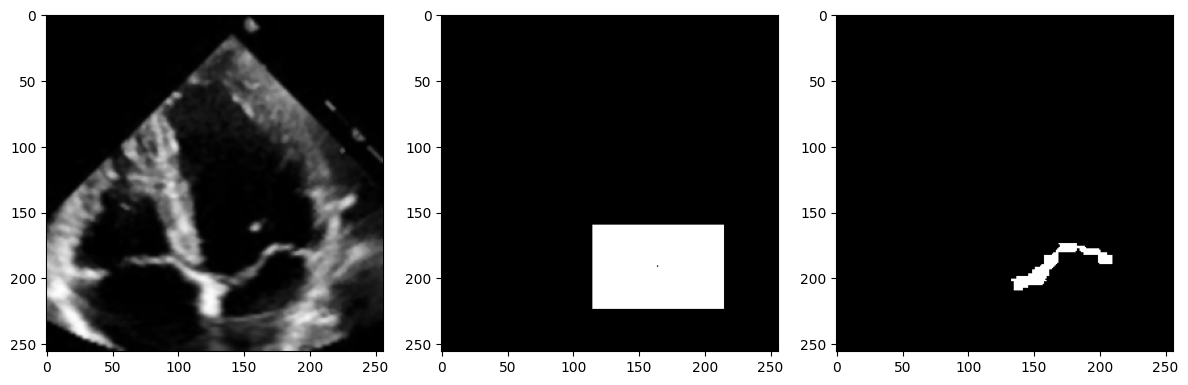

In [90]:
f = 0

frame_f = all_train_dataset.frames_data[f]
box_f = all_train_dataset.boxes_data[f]
label_f = all_train_dataset.labels_data[f]

center_x, center_y = all_train_dataset.centers_data[f]
center_x, center_y = center_x.astype(int), center_y.astype(int)
box_f[center_x][center_y] = False

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(frame_f, cmap='gray')
axs[1].imshow(box_f, cmap='gray')
axs[2].imshow(label_f, cmap='gray')

    
plt.tight_layout()
plt.show()

## Models

In [110]:
class BoxModel(nn.Module):
    def __init__(self):
        super(BoxModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # (batch_size, 16, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (batch_size, 16, 128, 128)
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (batch_size, 32, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (batch_size, 32, 64, 64)
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (batch_size, 64, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (batch_size, 64, 32, 32)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 2) 
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [148]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SimpleUNet, self).__init__()

        # Encoder (Downsampling path)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (Upsampling path)
        self.upconv4 = self.upconv_block(1024, 512)
        self.dec4 = self.conv_block(1024, 512)  # 512 (up) + 512 (cropped encoder)

        self.upconv3 = self.upconv_block(512, 256)
        self.dec3 = self.conv_block(512, 256)  # 256 (up) + 256 (cropped encoder)

        self.upconv2 = self.upconv_block(256, 128)
        self.dec2 = self.conv_block(256, 128)  # 128 (up) + 128 (cropped encoder)

        self.upconv1 = self.upconv_block(128, 64)
        self.dec1 = self.conv_block(128, 64)   # 64 (up) + 64 (cropped encoder)

        # Output layer with target size (N, 1, 96, 96)
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Convolutional block with Conv2D + BatchNorm + ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        """Upsampling block with ConvTranspose2D"""
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def crop_and_concat(self, encoder_features, decoder_features):
        """Crop encoder features to match decoder dimensions and concatenate"""
        _, _, H, W = decoder_features.size()
        _, _, H_enc, W_enc = encoder_features.size()
        crop_h = (H_enc - H) // 2
        crop_w = (W_enc - W) // 2
        enc_cropped = encoder_features[:, :, crop_h:crop_h+H, crop_w:crop_w+W]
        return torch.cat([enc_cropped, decoder_features], dim=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)                           # (N, 64, 256, 256)
        enc2 = self.enc2(F.max_pool2d(enc1, 2, 2))    # (N, 128, 128, 128)
        enc3 = self.enc3(F.max_pool2d(enc2, 2, 2))    # (N, 256, 64, 64)
        enc4 = self.enc4(F.max_pool2d(enc3, 2, 2))    # (N, 512, 32, 32)

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2, 2))  # (N, 1024, 16, 16)

        # Decoder
        up4 = self.upconv4(bottleneck)                # (N, 512, 32, 32)
        dec4 = self.dec4(self.crop_and_concat(enc4, up4))  # (N, 512, 32, 32)

        up3 = self.upconv3(dec4)                      # (N, 256, 64, 64)
        dec3 = self.dec3(self.crop_and_concat(enc3, up3))  # (N, 256, 64, 64)

        up2 = self.upconv2(dec3)                      # (N, 128, 128, 128)
        dec2 = self.dec2(self.crop_and_concat(enc2, up2))  # (N, 128, 128, 128)

        up1 = self.upconv1(dec2)                      # (N, 64, 256, 256)
        dec1 = self.dec1(self.crop_and_concat(enc1, up1))  # (N, 64, 256, 256)

        # Output
        out = self.out_conv(dec1)                     # (N, 1, 256, 256)
        out = F.interpolate(out, size=(128, 128), mode='bilinear', align_corners=False)
        return torch.sigmoid(out)  # Final shape: (N, 1, 96, 96)

## Train Box finding

In [114]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_train_dataset.box = True
train_loader = DataLoader(all_train_dataset, batch_size=16, shuffle=True)

box_model = BoxModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(box_model.parameters(), lr=0.001)
losses = []

# Training loop
def train_model(train_loader, model, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for frame_batch, center_batch in train_loader: # images: (batch_size, 1, 256, 256), targets: (batch_size, 4)
            optimizer.zero_grad()
            outputs = model(frame_batch.unsqueeze(1))
            loss = criterion(outputs, center_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss/len(train_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

        
train_model(train_loader, box_model, criterion, optimizer, num_epochs=25)

Epoch 1/25, Loss: 5311.3390221228965
Epoch 2/25, Loss: 873.1054452749399
Epoch 3/25, Loss: 484.0664391150841
Epoch 4/25, Loss: 546.6232745830829
Epoch 5/25, Loss: 331.3172108576848
Epoch 6/25, Loss: 234.94855499267578
Epoch 7/25, Loss: 197.2650576371413
Epoch 8/25, Loss: 101.69774568997897
Epoch 9/25, Loss: 59.66546704218938
Epoch 10/25, Loss: 40.38291637714092
Epoch 11/25, Loss: 25.52727845998911
Epoch 12/25, Loss: 17.713215754582333
Epoch 13/25, Loss: 14.363132330087515
Epoch 14/25, Loss: 8.901926920964168
Epoch 15/25, Loss: 7.640976318946252
Epoch 16/25, Loss: 7.99335371530973
Epoch 17/25, Loss: 10.149813431959887
Epoch 18/25, Loss: 5.327576554738558
Epoch 19/25, Loss: 2.8125993380179772
Epoch 20/25, Loss: 2.5812535010851345
Epoch 21/25, Loss: 1.210863640675178
Epoch 22/25, Loss: 1.0494577884674072
Epoch 23/25, Loss: 0.8098181554904351
Epoch 24/25, Loss: 0.4590436839140378
Epoch 25/25, Loss: 0.31488482711406857


In [176]:
torch.save(box_model, "models/box_model.pth")
#test_model = torch.load("models/box_model.pth")
#print(test_model)

## BoxModel Testing

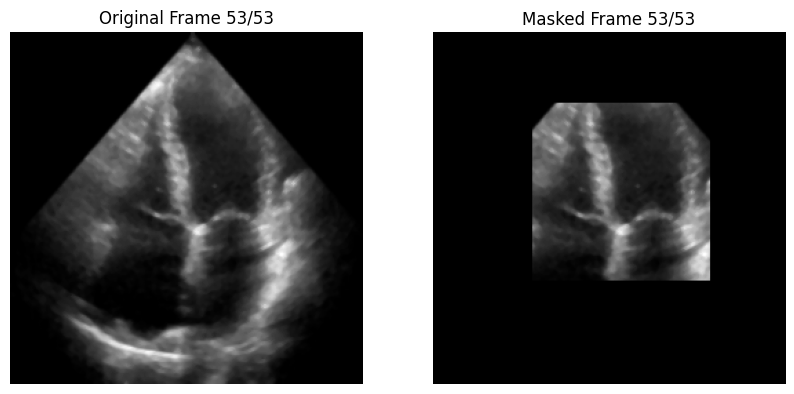

In [124]:
all_train_dataset.box = False

test_video = test_data[4]['video']
vid = np.zeros((256,256,test_video.shape[2]))
for i in range(test_video.shape[2]):
    vid[:,:,i] = smooth_frame(cv2.resize(test_video[:,:,i].astype(np.uint8), (256, 256)))
   

vid = torch.FloatTensor(vid)
frames = vid.unsqueeze(0)
frames = frames.permute(3, 0, 1, 2)
#print(frames.shape)


box_model.eval()
frame_box_coords = box_model(frames)
boxes = reconstruct_box_centers_batch(frame_box_coords)

video_frames = frames.squeeze().permute(1, 2, 0)
video_boxes = boxes.permute(1, 2, 0)
#print(video_frames.shape)
#print(video_boxes.shape)

show_video(frames=video_frames.detach().numpy(), masks=video_boxes.detach().numpy(), speed=0.0001)


## Homogenize Box size in datasets

In [144]:
def crop_frames_adjust_boxes_dataset(dataset):
    boxes = dataset.boxes_data
    new_boxes = []
    
    for i in range(len(boxes)):
        new_boxes.append(substitute_with_my_box(boxes[i]))
    
    new_boxes = np.array(new_boxes) 
    dataset.boxes_data = new_boxes
    
    frames = dataset.frames_data
    boxes = dataset.boxes_data
    cropped_frames = []
    
    for i in range(len(frames)):
        cropped_frames.append(get_cropped_frame(frames[i], boxes[i]))
        
    new_frames = np.array(cropped_frames)
    dataset.cropped_frames_data = new_frames
    
    labels = dataset.labels_data
    cropped_labels = []
    
    for i in range(len(labels)):
        cropped_labels.append(get_cropped_frame(labels[i], boxes[i]))
        
    new_labels = np.array(cropped_labels)
    dataset.cropped_labels_data = new_labels

        
        
crop_frames_adjust_boxes_dataset(amateur_train_dataset)
print("Adjusted the Amateur Set")
crop_frames_adjust_boxes_dataset(expert_train_dataset)
print("Adjusted the Expert Set")
crop_frames_adjust_boxes_dataset(all_train_dataset)
print("Adjusted the All Set")

Adjusted the Amateur Set
Adjusted the Expert Set
Adjusted the All Set


## Train UNET

In [154]:
#unet_model = SimpleUNet()
optimizer_unet = torch.optim.Adam(unet_model.parameters(), lr=1e-4)

amateur_train_dataset.unet = True
train_loader_amateur = DataLoader(amateur_train_dataset, batch_size=16, shuffle=True)
num_epoch = 20

for epoch in range(num_epoch):
    unet_model.train()
    total_loss = 0

    for cropped_frame_batch, cropped_label_batch in train_loader_amateur:
        
        cropped_frame_batch, cropped_label_batch = cropped_frame_batch.to(device), cropped_label_batch.to(device)
        cropped_frame_batch = cropped_frame_batch.unsqueeze(1)
        optimizer_unet.zero_grad()
        
        preds = unet_model(cropped_frame_batch)
        preds = preds.squeeze()
    
        loss = F.binary_cross_entropy(preds, cropped_label_batch)

        loss.backward()
        optimizer_unet.step()
        
        total_loss += loss.item()    
    print(f"Epoch {epoch+1}/{num_epoch}, Loss: {total_loss/len(train_loader_amateur)}")

Epoch 1/20, Loss: 0.20251776940292782
Epoch 2/20, Loss: 0.19829494423336452
Epoch 3/20, Loss: 0.19395597610208723
Epoch 4/20, Loss: 0.1895878811677297
Epoch 5/20, Loss: 0.18593357337845695
Epoch 6/20, Loss: 0.18269614378611246
Epoch 7/20, Loss: 0.17946971125072902
Epoch 8/20, Loss: 0.17623595065540737
Epoch 9/20, Loss: 0.17321038246154785
Epoch 10/20, Loss: 0.17046800918049282
Epoch 11/20, Loss: 0.16743129160669115
Epoch 12/20, Loss: 0.16447904209295908
Epoch 13/20, Loss: 0.16192514035436842
Epoch 14/20, Loss: 0.15919694801171622
Epoch 15/20, Loss: 0.1564258767498864
Epoch 16/20, Loss: 0.15415051248338488
Epoch 17/20, Loss: 0.15169493191772038
Epoch 18/20, Loss: 0.14927001297473907
Epoch 19/20, Loss: 0.14656302995151943
Epoch 20/20, Loss: 0.14429663287268746


In [156]:
expert_train_dataset.unet = True
train_loader_expert = DataLoader(expert_train_dataset, batch_size=8, shuffle=True)
num_epoch = 30

for epoch in range(num_epoch):
    unet_model.train()
    total_loss = 0

    for cropped_frame_batch, cropped_label_batch in train_loader_expert:
        
        cropped_frame_batch, cropped_label_batch = cropped_frame_batch.to(device), cropped_label_batch.to(device)
        cropped_frame_batch = cropped_frame_batch.unsqueeze(1)
        optimizer_unet.zero_grad()
        
        preds = unet_model(cropped_frame_batch)
        preds = preds.squeeze()
    
        loss = F.binary_cross_entropy(preds, cropped_label_batch.squeeze())

        loss.backward()
        optimizer_unet.step()
        
        total_loss += loss.item()    
    print(f"Epoch {epoch+1}/{num_epoch}, Loss: {total_loss/len(train_loader_amateur)}")

Epoch 1/30, Loss: 0.234663392106692
Epoch 2/30, Loss: 0.1731797026263343
Epoch 3/30, Loss: 0.16971287628014883
Epoch 4/30, Loss: 0.1647714012198978
Epoch 5/30, Loss: 0.15355253550741407
Epoch 6/30, Loss: 0.14223924610349867
Epoch 7/30, Loss: 0.13949506150351632
Epoch 8/30, Loss: 0.13652223348617554
Epoch 9/30, Loss: 0.13400674859682718
Epoch 10/30, Loss: 0.1284436451064216
Epoch 11/30, Loss: 0.12523144980271658
Epoch 12/30, Loss: 0.1229239735338423
Epoch 13/30, Loss: 0.1208318206999037
Epoch 14/30, Loss: 0.11916440725326538
Epoch 15/30, Loss: 0.11728203462229835
Epoch 16/30, Loss: 0.1169558929072486
Epoch 17/30, Loss: 0.1134257200691435
Epoch 18/30, Loss: 0.11611423227522108
Epoch 19/30, Loss: 0.11472504254844454
Epoch 20/30, Loss: 0.11260258820321825
Epoch 21/30, Loss: 0.10930338833067152
Epoch 22/30, Loss: 0.10683406475517485
Epoch 23/30, Loss: 0.10457106431325276
Epoch 24/30, Loss: 0.10322201583120558
Epoch 25/30, Loss: 0.10115201357338163
Epoch 26/30, Loss: 0.09931501166688071
Epoc

In [178]:
torch.save(unet_model, "models/unet_model.pth")

## UNET testing

C:\Users\marti\AppData\Local\Temp\ipykernel_9264\445903463.py:110: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cropped_frame[0:(x2-x1), 0:(y2-y1)] = frame[x1:x2, y1+1:y2+1]


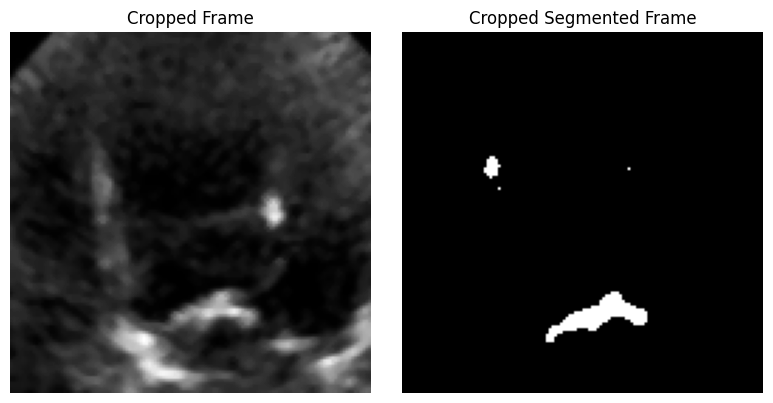

In [160]:
test_video_0 = test_data[17]['video']
vid = np.zeros((256,256,test_video_0.shape[2]))
for i in range(test_video_0.shape[2]):
    vid[:,:,i] = smooth_frame(cv2.resize(test_video_0[:,:,i].astype(np.uint8), (256, 256)))
    
vid = vid[:,:,0:5]
vid = torch.FloatTensor(vid)
frames = vid.unsqueeze(0)
frames = frames.permute(3, 0, 1, 2)

box_model.eval()
frame_box_coords = box_model(frames)
frames = frames.squeeze()
boxes = reconstruct_box_centers_batch(frame_box_coords)

cropped_frames = []
for i in range(5):
    cropped_frames.append(get_cropped_frame(frames[i], boxes[i]))
    
cropped_frames = torch.FloatTensor(np.array(cropped_frames))
cropped_frames = cropped_frames.unsqueeze(1)


unet_model.eval()
segmented_cropped_frame = unet_model(cropped_frames)
#print("Segmented Cropped Frames shape:")
#print(segmented_cropped_frame.shape)

for i in range(1):
    abba = segmented_cropped_frame[i].squeeze().detach().numpy()
    abba = abba > 0.5

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    # Plot the frame without mask
    axs[0].imshow(cropped_frames[i,:,:].squeeze(), cmap='gray')
    title0 = "Cropped Frame"
    axs[0].set_title(title0)
    axs[0].axis('off')
    
    # Plot the frame with mask
    axs[1].imshow(abba, cmap='gray')
    title1 = "Cropped Segmented Frame"
    axs[1].set_title(title1)
    axs[1].axis('off') 
    
    plt.tight_layout()
    plt.show()

## Final Evaluation

In [169]:
def decrop_video(video, video_centers):
    video_centers = video_centers.detach().numpy()
    video = video.detach().numpy()
    
    uncropped_video = np.zeros((video.shape[0], 256, 256), dtype=bool)
    
    top_lefts = []
    for i in range(video.shape[0]):
        center = video_centers[i,:]
        top_lefts.append((center[0]-64., center[1]-64.))
        
    top_lefts = np.array(top_lefts).astype(int)
    
    for i in range(video.shape[0]):
        video[i,:,:] = video[i,:,:] > 0.5
        for j in range(128):
            for k in range(128):
                if((j + top_lefts[i][0] < 256) and (k + top_lefts[i][1] < 256)):
                    uncropped_video[i][j + top_lefts[i][0]][k + top_lefts[i][1]] = video[i][j][k]
                
    return uncropped_video

In [171]:
index = 0
item = test_data[index]
video = item['video']
original_height, original_width, _ = video.shape 

video = cv2.resize(video.astype(np.uint8), (256, 256))
video = video.transpose((2, 0, 1))
video = smooth_video(video)
video = np.expand_dims(video, axis=1)
video = torch.FloatTensor(video)

box_model.eval()
video_centers = box_model(video)
boxes_video = reconstruct_box_centers_batch(video_centers)
video = video.squeeze()

cropped_frames = []
for i in range(video.shape[0]):
    cropped_frames.append(get_cropped_frame(video[i,:,:], boxes_video[i,:,:]))

cropped_video = torch.FloatTensor(np.array(cropped_frames))
cropped_video = cropped_video.unsqueeze(1)

unet_model.eval()
segmented_cropped_video = unet_model(cropped_video)
segmented_cropped_video = segmented_cropped_video.squeeze()

segmented_video = decrop_video(segmented_cropped_video, video_centers)

#Resize to original shape
final_video = []
for i in range(video.shape[0]):
    final_frame = resize_boolean_array(segmented_video[i,:,:], (original_height, original_width))
    final_video.append(final_frame)
final_video = np.array(final_video)


print(final_video.shape)
#segmented_videos.append(final_video)

C:\Users\marti\AppData\Local\Temp\ipykernel_9264\445903463.py:110: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cropped_frame[0:(x2-x1), 0:(y2-y1)] = frame[x1:x2, y1+1:y2+1]


(103, 586, 821)


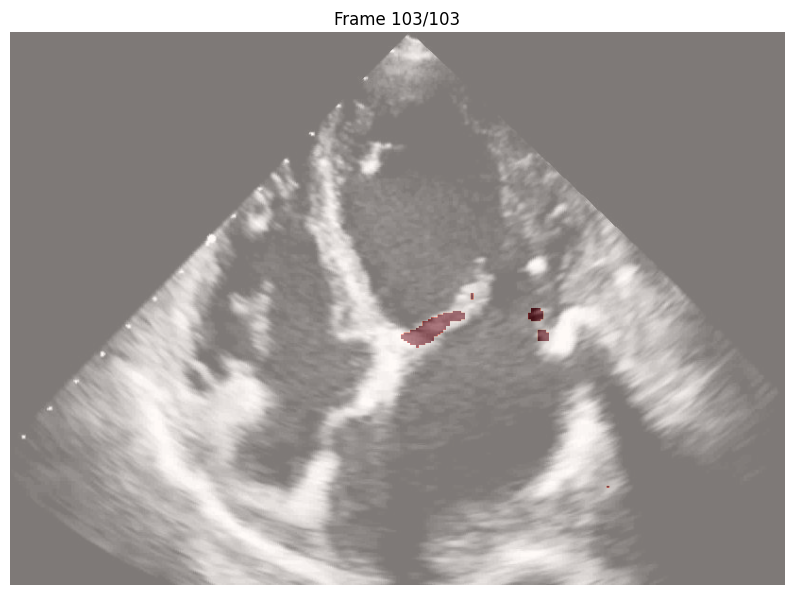

In [173]:
plt.figure(figsize=(10, 10))
index = 0
video = final_video
num_frames = video.shape[0]
    
for i in range(num_frames):
    plt.clf()  
    plt.imshow(test_data[index]['video'][:,:,i], cmap='gray')
    plt.imshow(video[i, :, :], cmap="Reds", alpha=0.5)
    plt.axis('off')
    plt.title(f"Frame {i+1}/{num_frames}")

    display(plt.gcf())
    clear_output(wait=True)
    time.sleep(0.001)